<img src=../figures/Brown_logo.svg width=50%>

## Data-Driven Design & Analyses of Structures & Materials (3dasm)

## Lecture 19

### Martin van der Schelling | <a href = "mailto: m.p.vanderschelling@tudelft.nl">m.p.vanderschelling@tudelft.nl</a>  | Doctoral Candidate

### Miguel A. Bessa | <a href = "mailto: miguel_bessa@brown.edu">miguel_bessa@brown.edu</a>  | Associate Professor

**What:** A lecture of the "3dasm" course

**Where:** This notebook comes from this [repository](https://github.com/bessagroup/3dasm_course)

**Reference for entire course:** Murphy, Kevin P. *Probabilistic machine learning: an introduction*. MIT press, 2022. Available online [here](https://probml.github.io/pml-book/book1.html)

**How:** We try to follow Murphy's book closely, but the sequence of Chapters and Sections is different. The intention is to use notebooks as an introduction to the topic and Murphy's book as a resource.
* If working offline: Go through this notebook and read the book.
* If attending class in person: listen to me (!) but also go through the notebook in your laptop at the same time. Read the book.
* If attending lectures remotely: listen to me (!) via Zoom and (ideally) use two screens where you have the notebook open in 1 screen and you see the lectures on the other. Read the book.

## **OPTION 1**. Run this notebook **locally in your computer**:
1. Confirm that you have the '3dasm' mamba (or conda) environment (see Lecture 1).
2. Go to the 3dasm_course folder in your computer and pull the last updates of the [repository](https://github.com/bessagroup/3dasm_course):
```
git pull
```
    - Note: if you can't pull the repo due to conflicts (and you can't handle these conflicts), use this command (with **caution**!) and your repo becomes the same as the one online:
```
git reset --hard origin/main
```
3. Open command window and load jupyter notebook (it will open in your internet browser):
```
jupyter notebook
```
5. Open notebook of this Lecture and choose the '3dasm' kernel.

## **OPTION 2**. Use **Google's Colab** (no installation required, but times out if idle):

1. go to https://colab.research.google.com
2. login
3. File > Open notebook
4. click on Github (no need to login or authorize anything)
5. paste the git link: https://github.com/bessagroup/3dasm_course
6. click search and then click on the notebook for this Lecture.

In [1]:
# Basic plotting tools needed in Python.

import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

# To limit the number of rows to show in a dataframe, for presentation purposes:
import pandas as pd

pd.set_option('display.max_rows', 10)

## Outline for today

* Introducing advanced usage of the `f3dasm.datageneration` submodule using the `DataGenerator`
* Using the built-in features of `f3dasm`: samplers and benchmark functions
* Basic usage of optimization

**Reading material**: This notebook + `f3dasm` documentation page ([link](https://f3dasm.readthedocs.io/en/latest/))

### Installing `f3dasm`

You can install `f3dasm` with pip:

_Make sure you install the correct version (2.1.0)_

In [ ]:
try:
    import f3dasm
except ModuleNotFoundError: # If f3dasm is not found in current environment, install the correct version from pip
    %pip install f3dasm==2.1.0 --quiet
    import f3dasm

Optionally, it is also possible to install from source:

```
git clone https://github.com/bessagroup/f3dasm
pip install -e .
```

For more installation instruction you can check the [installation documentation](https://github.com/bessagroup/f3dasm)

### `f3dasm`: streamlining your data-driven process!

The **f**ramework for **d**ata-**d**riven **d**esign and **a**nalysis of **s**tructures and **m**aterials (`f3dasm`) aims to generalize this workflow with interfaces (templates of code that you have to fill in)


<center><img src="../figures/f3dasm_overview.svg" title="f3dasm Car stopping distance" width="70%"></center>

#### FAQ

**Does `f3dasm` contain fancy machine learning models and simulation software?**

- No, there are many other packages providing you the tools to create machine learning models (jax, pytorch, scikit-learn etc.) or material simulators (ABAQUS, Fenics)
- But you can wrap those models in `f3dasm` objects!

**But what comes in the box then?**

- `f3dasm` facilitates common interfaces where you need to provide the implementation for it!
- Think about it as a template where you need to fill in the blanks

**What is the advantage of using `f3dasm`?**

By wrapping your code into this common interface, you:
- Don't waste time implementing common data-driven procedure (e.g. data management and parallelization); this is done for you
- Allow other `f3dasm` users to use your model right away, since you have the same interfaces!
- Force your research to obide the FAIR principles (**F**indable, **A**ccessible, **I**nteroperable and **R**eusable)

<center><img src="../figures/f3dasm_overview.svg" title="f3dasm Car stopping distance" width="30%"></center>

### Advanced data generation with `f3dasm`

First, we load the `ExperimentData` with our car velocities from the previous lecture:

In [3]:
import numpy as np
from f3dasm import ExperimentData # Import the ExperimentData class
from f3dasm.design import Domain # Import the Domain class from the design submodule
from f3dasm import datagenerator

domain = Domain() # Creat the Domain object
domain.add_float('x', low=3.0, high=83.0) # add the car velocity x to the domain
Data_x = np.linspace(3, 83, 33) # create 33 points, uniformly spaced between 3 and 83

my_experimentdata = ExperimentData(input_data=Data_x, domain=domain)
my_experimentdata

,jobs,input
,,x
0,open,3.0
1,open,5.5
2,open,8.0
3,open,10.5
4,open,13.0
...,...,...
28,open,73.0
29,open,75.5
30,open,78.0


_We can also load the `ExperimentData` from the previous lecture, though it includes the car stopping distances (`y`) and the predicted values (`y_pred`). To reuse the data, we can remove these output fields and then mark the jobs as open again._

In [4]:
my_experimentdata = ExperimentData.from_file('../Lecture17/your_data')

Data_x, _ = my_experimentdata.to_pandas()
my_experimentdata = ExperimentData(input_data=Data_x, domain=my_experimentdata.domain)
my_experimentdata = my_experimentdata.mark_all('open')

Previously we have seen that we can feed a **function** to the `ExperimentData` object in order to evaluate each design:

In [5]:
from scipy.stats import norm # import the normal dist, as we learned before!

# Define our car stopping distance function
@datagenerator(output_names=['y'])
def compute_distance(x: float) -> float:
    z = norm.rvs(1.5, 0.5, size=1) # randomly draw 1 sample from the normal dist.
    y = z*x + 0.1*x**2 # compute the stopping distance
    return float(y)

#### Creating a `DataGenerator` class

<img src="../figures/f3dasm_carstopping_datageneration.svg" title="f3dasm Car stopping distance datageneration" width="22%" align="right">

However, we might want to create a custom class that has custom attributes and methods to allow more flexibility over the data generation process. 

I will show you how we can create the same car stopping distance dataset but now with an object-oriented approach.

In order to do this, you have to create a new class that inherits from the `f3dasm.datageneration.DataGenerator` class:

In [6]:
from f3dasm.datageneration import DataGenerator

In [7]:
class CarStoppingDistance(DataGenerator):
    def __init__(self, mu_z: float, sigma_z: float):
        self.mu_z = mu_z
        self.sigma_z = sigma_z
            
    def execute(self, experiment_sample):
        x = experiment_sample.get('x')
        z = norm.rvs(self.mu_z, self.sigma_z, size=1)
        y = z*x + 0.1*x**2
        experiment_sample.store(name='y', object=float(y.item()))
        return experiment_sample

#### Implementing the `execute()` method

- The custom class `CarStoppingDistance` can have any methods or attributes that you want
- It requires you to implement the `execute()` method
- This method will be called for every experiment when you evaluate the `ExperimentData`.
- A single experiment is called an `ExperimentSample`

#### The `ExperimentSample` object
- Each experiment will be converted into an `ExperimentSample` object
- The `ExperimentSample` can be seen as a 'row' in the table of experiments
- It can be accessed in the `execute()` method as `self.experiment_sample`

In [8]:
my_experimentdata

,jobs,input
,,x
0,open,3.0
1,open,5.5
2,open,8.0
3,open,10.5
4,open,13.0
...,...,...
28,open,73.0
29,open,75.5
30,open,78.0


In [9]:
my_experimentsample = my_experimentdata.get_experiment_sample(2)
print(my_experimentsample)

ExperimentSample(input_data={'x': 8.0}, output_data={}, job_status=JobStatus.OPEN)


We can access the current `input_data`, `output_data` and `job_status` from the experiment sample

In [10]:
print(f" Input data: {my_experimentsample.input_data}")
print(f" Output data: {my_experimentsample.output_data}")
print(f" Job number: {my_experimentsample.job_status}")

 Input data: {'x': 8.0}
 Output data: {}
 Job number: JobStatus.OPEN


Alternatively, the `get()` method can also retrieve individual parameters:

In [11]:
my_experimentsample.get('x')

8.0

Another useful feature is to convert the experiment sample object to a tuple of numpy arrays:

In [12]:
print(my_experimentsample.to_numpy())

(array([8.]), array([], dtype=float64))


Storing objects back into the `ExperimentData` object can be done with the `store()` method

In [13]:
my_experimentsample.store(name='y', object=3.4)
my_experimentsample

ExperimentSample(input_data={'x': 8.0}, output_data={'y': 3.4}, job_status=JobStatus.OPEN)

#### Running the datagenerator on your experimentdata

Now we are going to compute the car stopping distance with our custom class!

First, we are creating an object from the `CarStoppingDistance` class with our chosen $\mu_z$ and $\sigma_z$

In [14]:
csd = CarStoppingDistance(mu_z=1.5, sigma_z=0.5)

Now we call evaluate on the `ExperimentData` (we don't need to provide `output_names` for the custom class approach since we decided on them in the `store` method of the `ExperimentSample`)

In [15]:
my_experimentdata = csd.call(data=my_experimentdata)

In [16]:
my_experimentdata

,jobs,input,output
,,x,y
0,finished,3.0,2.970653
1,finished,5.5,11.561784
2,finished,8.0,23.546985
3,finished,10.5,24.592015
4,finished,13.0,29.379763
...,...,...,...
28,finished,73.0,630.428280
29,finished,75.5,685.187420
30,finished,78.0,741.516788


### Easy parallelization

One common procedure that everyone encounters at some point is **parallelization**.

&#x1F31F; `ExperimentData.evaluate` offers three different modes of evaluating all the experiments:
- `sequential` mode: evaluates each experiment one at a time (default)
- `parallel` mode: using multiprocessing capabilities, evaluating the experments in parallel on your cores
- `cluster` mode: after each writing operation, saves the `ExperimentData` object to disk so it can be accessed by different processes. Useful for the Brown CCV

In [17]:
domain = Domain() # Create a new Domain object
domain.add_int(name='x', low=0, high=5) # Add an arbitrary parameter to it

experimentdata_sequential = ExperimentData(input_data=np.arange(0, 5), domain=domain)
experimentdata_parallel = ExperimentData(input_data=np.arange(0, 5), domain=domain)

For demonstration purposes, we create a custom `DataGenerator` that just waits 1 second:

In [18]:
from time import sleep, perf_counter

class Sleep(DataGenerator):
    def execute(self, experiment_sample):
        # Elaborate process, but for now just sleep 1 second
        sleep(1)
        return experiment_sample

my_datagenerator = Sleep() # Create the custom data generator

We evaluate both `ExperimentData` objects with `'sequential'` and `'parallel'` mode:

In [19]:
# Evaluate the experimentdata in sequential mode
t_start = perf_counter()
experimentdata_sequential = my_datagenerator.call(data=experimentdata_sequential, mode='sequential')
print(f"Time took for sequential: {perf_counter() - t_start:.2f} seconds.")

# Evaluate the experimentdata in parallel mode
t_start = perf_counter()
experimentdata_parallel = my_datagenerator.call(data=experimentdata_parallel, mode='parallel', nodes=3)
print(f"Time took for sequential: {perf_counter() - t_start:.2f} seconds.")

Time took for sequential: 5.01 seconds.
Time took for sequential: 1.06 seconds.


### Store more complex data

&#x1F31F; To store more complex, array-like, or custom objects, you can use the optional argument `to_disk=True`. This will save the object to disk and retain only a reference to it within the `ExperimentData` object.

We demonstrate this by creating a datagenerator that generates a numpy array as output:

The input data `n_dim` denotes the size of the square matrix.

In [20]:
domain = Domain()
domain.add_int('n_dim', low=1, high=3)
Data_x = np.arange(1, 4)
experiment_data = ExperimentData(input_data=Data_x, domain=domain)

In [21]:
class MyDataGenerator(DataGenerator):
    def execute(self, experiment_sample):
        n_dim = experiment_sample.get('n_dim')
        my_array = np.ones((n_dim, n_dim))
        experiment_sample.store(name='my_array', object=my_array, to_disk=True)
        return experiment_sample
        
my_datagenerator = MyDataGenerator()

In [22]:
experiment_data.store('./your_data') # We store the ExperimentData first to disk
experiment_data = my_datagenerator.call(data=experiment_data)

The resulting `ExperimentData` object looks like this:

In [23]:
experiment_data

,jobs,input,output
,,n_dim,my_array
0,finished,1,my_array/0.npy
1,finished,2,my_array/1.npy
2,finished,3,my_array/2.npy


The numpy arrays are stored in a folder `my_array` in `your_data` directory:
```
your_data/
├── my_array/
│   ├── 0.npy
│   ├── 1.npy
│   └── 2.npy
└── experiment_data/
    ├── domain.json
    ├── input.csv
    ├── output.csv
    └── jobs.csv
```

`f3dasm` supports storing commonly used data types (`pd.DataFrame`, `numpy.array`, `xarray.DataArray` etc.)
But you can also [write your own storing protocol](https://f3dasm.readthedocs.io/en/latest/auto_examples/003_datageneration/003_storing.html#create-a-custom-storage-method)

<!-- ### Overview of methods for stage of the data-driven process

<table style="width: 100%; table-layout: fixed;">
  <tr>
    <td style="text-align: center; width: 25%;">
      <img src="../figures/f3dasm_design.svg" title="f3dasm design" width="100%">
    </td>
    <td style="text-align: center; width: 25%;">
      <img src="../figures/f3dasm_datageneration.svg" title="f3dasm datageneration" width="100%">
    </td>
    <td style="text-align: center; width: 25%;">
      <img src="../figures/f3dasm_machinelearning.svg" title="f3dasm machine learning" width="100%">
    </td>
    <td style="text-align: center; width: 25%;">
      <img src="../figures/f3dasm_optimization.svg" title="f3dasm optimization" width="100%">
    </td>
  </tr>
  <tr>
    <td style="text-align: center;"><code>f3dasm.design.Domain</code></td>
    <td style="text-align: center;"><code>f3dasm.datageneration.DataGenerator</code></td>
    <td style="text-align: center;"><code>-</code></td>
    <td style="text-align: center;"><code>f3dasm.optimization.Optimizer</code></td>
  </tr>
  <tr>
    <td style="text-align: center;"><code>ExperimentData.sample</code></td>
    <td style="text-align: center;"><code>ExperimentData.evaluate</code></td>
    <td style="text-align: center;"><code>-</code></td>
    <td style="text-align: center;"><code>ExperimentData.optimize</code></td>
  </tr>
</table> -->


### Built-in defaults

`f3dasm` comes with [built-in functionalities](https://f3dasm.readthedocs.io/en/latest/rst_doc_files/defaults.html#) for each of the stages of the data-driven process to get you started right away.

For each of the stages of the data-driven process, you can provide a string argument from the list of available options instead of a function/class object:

- **sampling**: `create_sampler('random')`
- **data generation**: `create_datagenerator('ackley')`
- **optimization**: `create_optimizer('cg')`

Today we are going to look at built-in sampling and built-in data generation

We can make an array parameter like this:

In [24]:
domain = Domain()
domain.add_array(name='x', shape=(2,), low=-10., high=10.)

We create an empty `ExperimentData` object with this domain:

In [25]:
experiment_data = ExperimentData(domain=domain)
experiment_data

""


#### Built-in sampling

We can call the `sample()` method and provide a sampler to add datapoints to our `ExperimentData` object:

In [26]:
from f3dasm import create_sampler

sampler = create_sampler('random', seed=123)
experiment_data = sampler.call(data=experiment_data, n_samples=10)

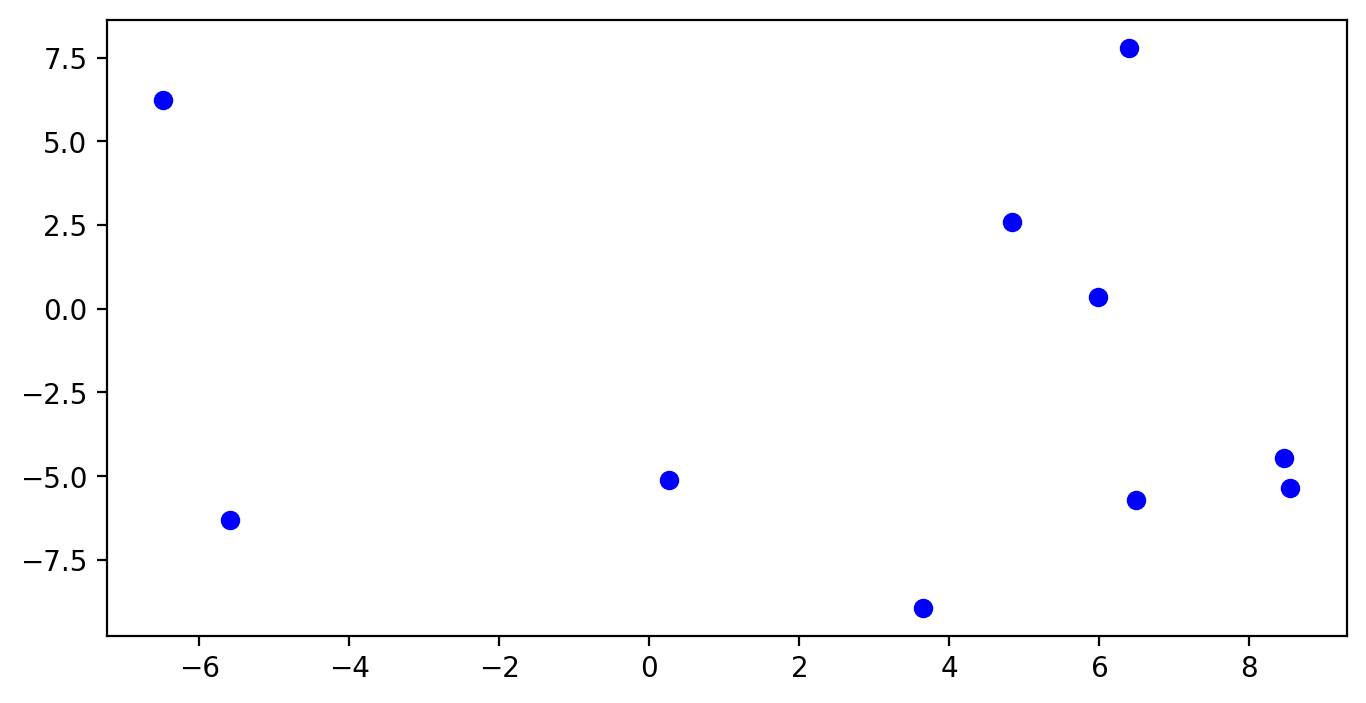

In [27]:
fig, ax = plt.subplots()
for i, es in experiment_data:
    x = es.get('x')
    ax.scatter(x[0], x[1], color='blue')

`f3dasm` comes with four [built-in samplers](https://f3dasm.readthedocs.io/en/latest/rst_doc_files/defaults.html#implemented-samplers):
- `random`: Random uniform sampling
- `latin`: Latin Hypercube sampling
- `sobol`: Sobol sequence sampling
- `grid`: Grid search sampling

/Users/martin/miniforge3/envs/3dasm/lib/python3.10/site-packages/scipy/stats/_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


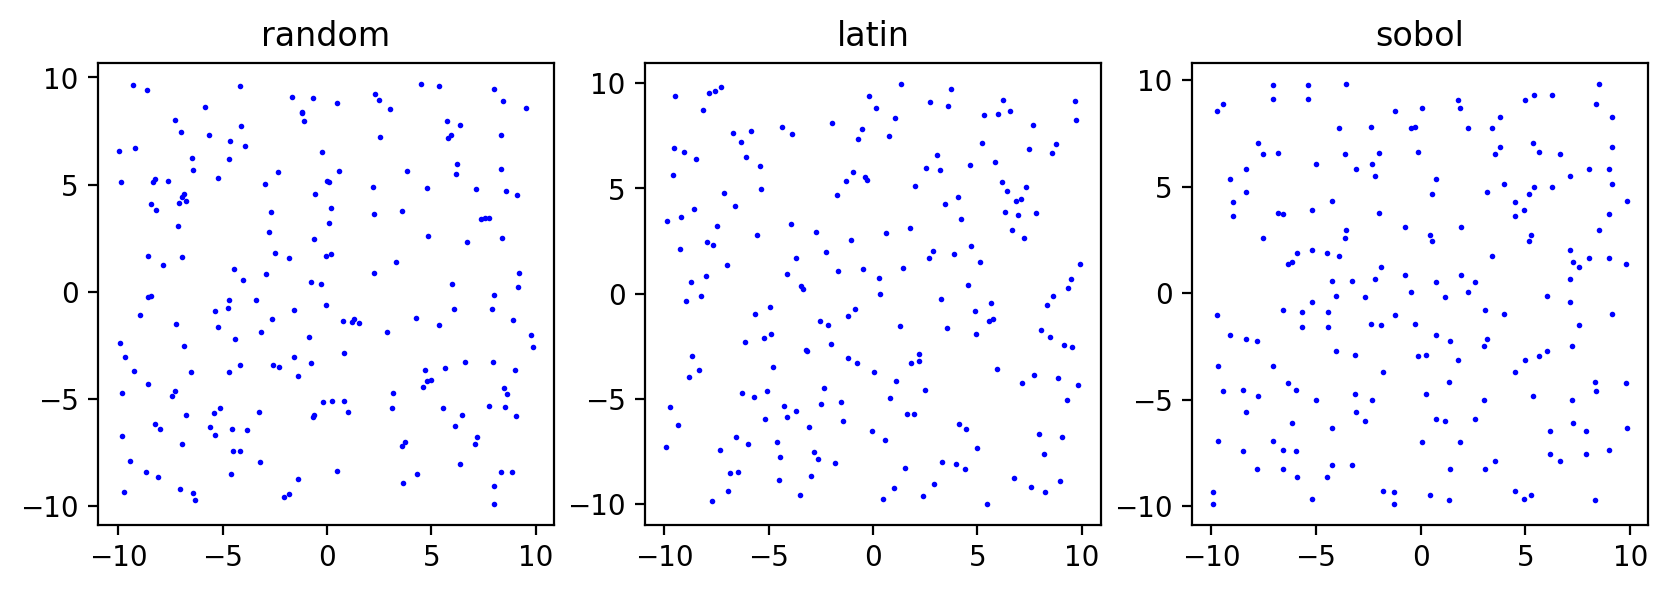

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for ax, sampler_name in zip(axes.flatten(), ['random', 'latin', 'sobol']):
    sampler = create_sampler(sampler_name, seed=123)
    edata = sampler.call(data=experiment_data, n_samples=200)
    for _, es in edata:
        x = es.get('x')
        ax.scatter(*x, s=1, color='blue')
    ax.set_title(sampler_name)

#### Built-in data generation

`f3dasm` comes with a [collection of benchmark functions](https://f3dasm.readthedocs.io/en/latest/rst_doc_files/defaults.html#implemented-benchmark-functions) that can used to evaluate your experiments.

For instance, the Levy function:

![Alt text](https://www.sfu.ca/~ssurjano/levy.png)

In [29]:
from f3dasm import create_datagenerator

data_generator = create_datagenerator('levy', output_names='y')

experiment_data = data_generator.call(data=experiment_data)

In [30]:
experiment_data

,jobs,input,output
,,x,y
0,finished,"[3.6470372649628686, -8.923579623955547]",7.461407
1,finished,"[-5.592802544547773, -6.312563786026606]",29.574500
2,finished,"[-6.481881978299393, 6.241890133115472]",40.909259
3,finished,"[8.466899960541127, -4.468512044057875]",17.052997
4,finished,"[6.395091231860043, 7.797853862223718]",21.728063
5,finished,"[0.25940910459063815, -5.1007079786240705]",2.776598
6,finished,"[6.484831921948228, -5.72474073249809]",20.770015
7,finished,"[4.829341044694193, 2.5988040917936157]",6.467240
8,finished,"[8.54814517050334, -5.361836227871624]",19.818509


A list of available benchmark functions is available on the [documentation page](https://f3dasm.readthedocs.io/en/latest/rst_doc_files/defaults.html#implemented-benchmark-functions) or as a list in the `f3dasm.datageneration` submodule:

### Optimization

<img src="../figures/f3dasm_optimization.svg" title="f3dasm optimization" width="22%" align="right">

Optimization can be performed on an `ExperimentData` object by:
- providing a data generator (built-in or custom)
- providing an optimization algorithm (built-in or custom)
- providing the number of iterations

In [31]:
from f3dasm import create_optimizer

optimizer = create_optimizer('lbfgsb')

optimizer.arm(data=experiment_data, data_generator=data_generator, output_name='y')

experiment_data += optimizer.call(data=experiment_data, n_iterations=30)


experiment_data

,jobs,input,output
,,x,y
0,finished,"[3.6470372649628686, -8.923579623955547]",7.461407e+00
1,finished,"[-5.592802544547773, -6.312563786026606]",2.957450e+01
2,finished,"[-6.481881978299393, 6.241890133115472]",4.090926e+01
3,finished,"[8.466899960541127, -4.468512044057875]",1.705300e+01
4,finished,"[6.395091231860043, 7.797853862223718]",2.172806e+01
...,...,...,...
12,finished,"[1.0000007572420657, 1.000001525521625]",6.783765e-04
13,finished,"[1.0000007572420657, 1.000001525521625]",3.779841e-05
14,finished,"[1.0000007572420657, 1.000001525521625]",2.453467e-07


A list of all the available optimization algorithms can be found on the [documentation page](https://f3dasm.readthedocs.io/en/latest/rst_doc_files/defaults.html#implemented-optimizers) or in the `f3dasm.optimization` sub-module

### Other things to explore ...

- &#x1F31F; [Hydra](https://hydra.cc/) configuration integration; seperating your constants and parameters from your code!
- &#x1F31F; [Studies](https://github.com/bessagroup/f3dasm/tree/main/studies), showcasing paper replications with the `f3dasm` worfklow
- &#x1F31F; [abaqus2py](https://pypi.org/project/abaqus2py/) port of managing multiple simulation of ABAQUS with `f3dasm` (under development)

### See you next class!

Useful links

- &#x1F31F; [GitHub repository](https://github.com/bessagroup/f3dasm)
- &#x1F4D5; [Online documentation](https://f3dasm.readthedocs.io/)
- &#x1F4F0; [JOSS Paper](https://doi.org/10.21105/joss.06912)

Give the repository a star &#x1F600; !